# Latent Space Optimal Transport by using Wasserstein-2 Generative Networks
DenseICNNs for fitting cycle monotone transport map in the autoencoders' latent space (CelebA dataset, rescaled to 64x64) dataset.
**GPU-only implementation.**
<img src="../pics/latent_ot.png" width=500 />

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

import os, sys
sys.path.append("..")

from copy import deepcopy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from tqdm import tqdm_notebook as tqdm
from sklearn.decomposition import PCA

torch.random.manual_seed(0xBADBEEF)

import json
import gc

In [2]:
from src.icnn import DenseICNN
from src.autoencoders import CelebaAutoencoder
from src.tools import read_image_folder, get_statistics_of_dataloader, get_generated_inception_stats
from src.fid_score import calculate_frechet_distance
from src import distributions
from src.plotters import plot_combined_generated, plot_latent_pca

### Config

In [3]:
CELEBA_64x64_PATH = '../data/img_align_celeba_64x64' # Images are expected to be of size 64x64
AE_CPKT_PATH = '../models/ae_celeba_vgg.tsd' # Use AE_Celeba.ipynb to pretrain or use our final checkpoint (VGG or MSE)
CELEBA_INC_STATS_PATH = '../models/celeba_inception_stats.json' # or None to recompute stats from scratch

TRANSFORM = lambda x: 2 * x - 1
INV_TRANSFORM = lambda x: (x+1) / 2
LAMBDA = 100.
BATCH_SIZE = 1024 * 4
GPU_DEVICE = 2
FID_INTERVAL = 25000

In [4]:
assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)

## Data loading

In [5]:
images = read_image_folder(CELEBA_64x64_PATH, n_jobs=40)

dataset_uint8 = np.array([
    np.array(im, dtype=np.uint16) for im in images
]).astype(np.uint8).transpose(0, 3, 1 ,2)

del(images)
gc.collect()

0

## Computation of CelebA Inception Statistics (for FID score)
or loading pre-computed values. Computation of Inception stats from scratch takes ~10 mins on GTX 1080ti.

In [6]:
if CELEBA_INC_STATS_PATH is None:    
    dataset_float = torch.utils.data.TensorDataset(torch.tensor(dataset_uint8, dtype=torch.float32) / 255.)
    loader = torch.utils.data.DataLoader(dataset_float, batch_size=8, pin_memory=True, shuffle=False, drop_last=False, num_workers=8)

    mu, sigma = get_statistics_of_dataloader(loader, cuda=True)
    
    with open('../models/celeba_inception_stats.json', 'w') as f:
        json.dump({"mu": mu.tolist(), "sigma": sigma.tolist()}, f)
        
    del dataset_float, loader
    torch.cuda.empty_cache()
    gc.collect()
    
else:
    with open(CELEBA_INC_STATS_PATH, 'r') as f:
        stats = json.load(f)
    mu = np.array(stats['mu'])
    sigma = np.array(stats['sigma'])
    
    del stats
    gc.collect()

## Autoencoder Loading

In [7]:
ae = CelebaAutoencoder(init_num_filters=128, embedding_dim=128, inter_fc_dim=512)
ae.load_state_dict(torch.load(AE_CPKT_PATH))
ae.cuda()
ae.eval()
print(np.sum([np.prod(list(p.shape)) for p in ae.parameters()]), 'params in AutoEncoder')

55859584 params in AutoEncoder


## Initialization of Latent Distribution

In [8]:
print(f'Generating {len(dataset_uint8)} latent vectors for the whole dataset.')
E_dataset = []
with torch.no_grad():
    for batch_start in tqdm(range(0, len(dataset_uint8), BATCH_SIZE)):
        E_dataset.append(
            ae.encoder(torch.tensor(
                TRANSFORM(dataset_uint8[batch_start:batch_start + BATCH_SIZE] / 255.),
                device='cuda', dtype=torch.float32
            )).cpu().detach().numpy()
        )
E_dataset = np.vstack(E_dataset)

# PCA (visualization purposes only)
print('Fitting PCA')
pca = PCA(n_components=6)
pca.fit(E_dataset)

# Requires only ~100mb of VRAM to store the latent vectors in GPU,
# so storage='cuda' is more preferrable for faster sampling
print('Initizlazing sampler')
E_sampler = distributions.TensorDatasetSampler(
    E_dataset, storage='cuda', requires_grad=True
)

del E_dataset
gc.collect()
torch.cuda.empty_cache()

Generating 202599 latent vectors for the whole dataset.



Fitting PCA
Initizlazing sampler


## Normal Latent Sampler

In [9]:
Z_sampler = distributions.StandartNormalSampler(128, requires_grad=True)

## Discriminators Setup

In [11]:
D = DenseICNN(128, [256, 256, 128, 64], rank=4, dropout=0, strong_convexity=1e-6).cuda()
D_conj = DenseICNN(128, [256, 256, 128, 64], rank=4, dropout=0, strong_convexity=1e-6).cuda()

for p in D.parameters():
    p.data = torch.randn(p.shape, device='cuda', dtype=torch.float32) / 10.

print(np.sum([np.prod(list(p.shape)) for p in D.parameters()]), 'params in Discriminative Network (D)')

557824 params in Discriminative Network (D)


Discriminator pretraining to satisfy $\nabla\psi_{\theta}(x)\approx x$.

In [12]:
pre_D_opt = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.8, 0.9), weight_decay=1e-10)
BLOW = 3.

D.train(True)
loss = np.inf

for iteration in tqdm(range(5000)):
    X = (Z_sampler.sample(BATCH_SIZE) * BLOW).requires_grad_(True)

    loss = ((D.push(X) - X) ** 2).sum(dim=1).mean()
    loss.backward()
    pre_D_opt.step()
    pre_D_opt.zero_grad()
    D.convexify()
    
    if iteration % 500 == 0:
        clear_output(wait=True)
        print('Pretraining the discriminator for D.push(x)=x')
        print('Current loss:', loss.item())
    
    if loss.item() < 1e-3:
        clear_output(wait=True)
        break
        
print('Final Loss:', loss.item())
D_conj.load_state_dict(D.state_dict())

Final Loss: 0.0009030841756612062


<All keys matched successfully>

## Testing plot functions for training visualization

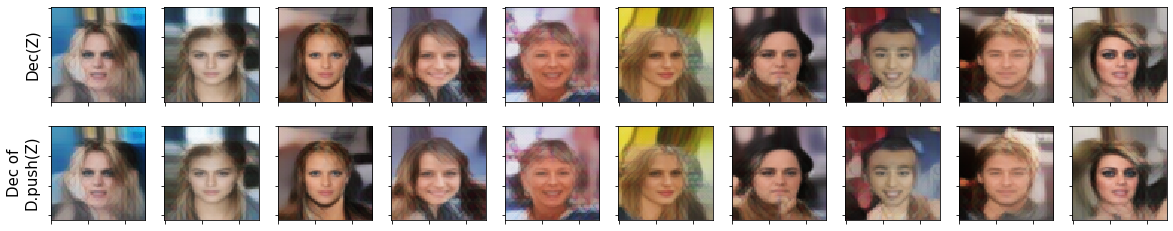

In [13]:
fig, axes = plot_combined_generated(ae.decoder, Z_sampler.sample(10), D, INV_TRANSFORM)
plt.close(fig)

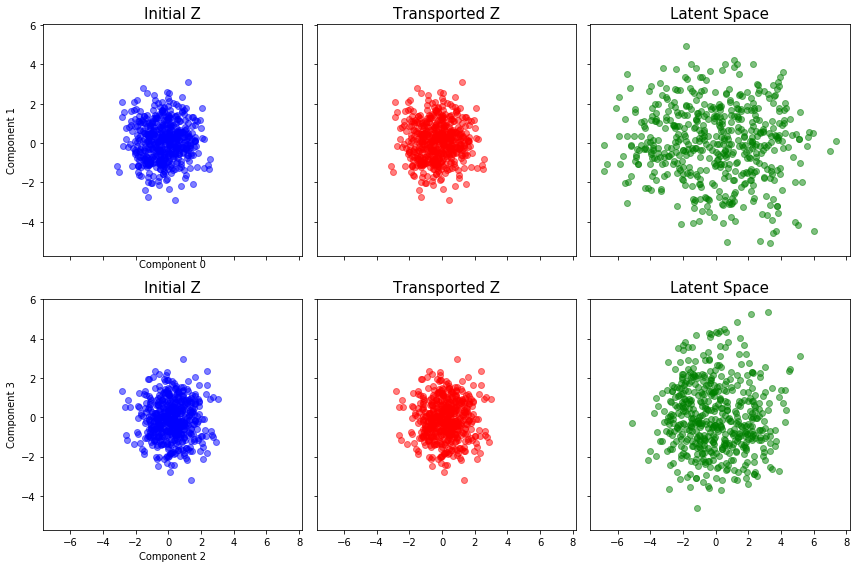

In [14]:
fig, axes = plot_latent_pca(Z_sampler.sample(512), E_sampler.sample(512), D, pca, n_pairs=2)
plt.close(fig)

## Main training of Latent Space Mass Transport

In [15]:
Z_fixed = Z_sampler.sample(10)
E_fixed = E_sampler.sample(10)

D_opt = torch.optim.Adam(D.parameters(), lr=3*1e-4, betas=(0.5, 0.999), weight_decay=1e-10)
D_conj_opt = torch.optim.Adam(D_conj.parameters(), lr=3*1e-4, betas=(0.5, 0.995), weight_decay=1e-10)

FID_history = []

Iteration 100000
Current FID: 17.21611346021018


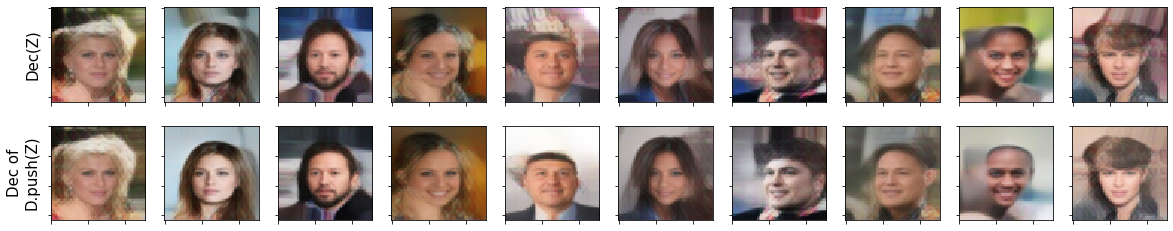

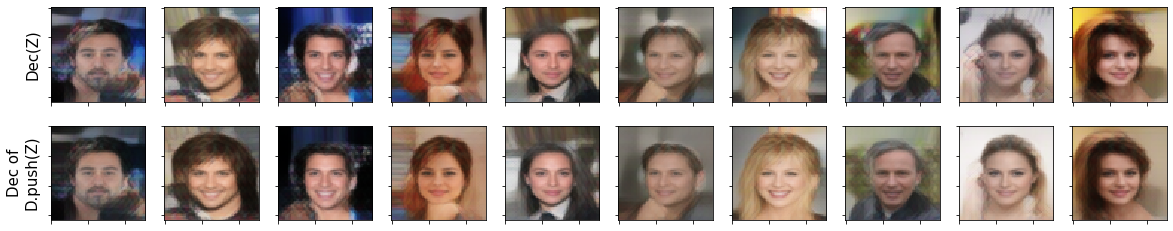

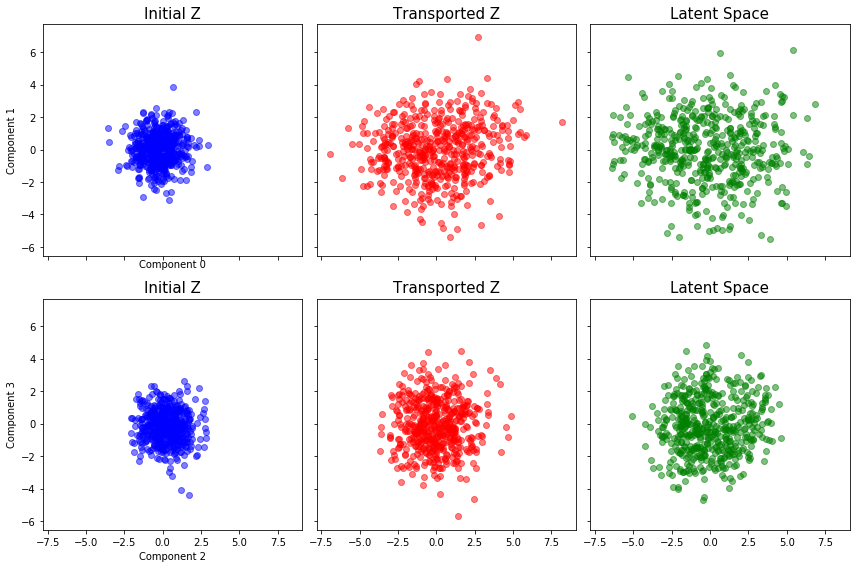

In [19]:
for it in range(100000+1):
    D.train(True); D_conj.train(True)
    Z = Z_sampler.sample(BATCH_SIZE)
    E = E_sampler.sample(BATCH_SIZE)
    
    Z_inv = D.push(Z).detach()
    D_conj_opt.zero_grad()
    D_opt.zero_grad()

    # Computing the loss
    W_loss = (D_conj(E) - D_conj(Z_inv)).mean() + (Z_inv * Z).flatten(start_dim=1).sum(dim=1).mean()
    with torch.no_grad():
        W_loss_nograd = ((-(E**2).flatten(start_dim=1).sum(dim=1) / 2).mean() - (Z**2).flatten(start_dim=1).sum(dim=1) / 2).mean().item()

    # Cycle Regularization
    D_cycle_loss = ((D_conj.push(D.push(Z)) - Z.detach()) ** 2).mean()
    D_conj_cycle_loss = ((D.push(D_conj.push(E)) - E.detach()) ** 2).mean()
    cycle_loss = (D_conj_cycle_loss + D_cycle_loss) / 2
    W_loss += LAMBDA * cycle_loss

    W_loss.backward()
    
    D_opt.step(); D_conj_opt.step()
    D_opt.zero_grad(); D_conj_opt.zero_grad()    
    D.convexify(); D_conj.convexify()
    D.train(False); D_conj.train(False)
        
    if (it % FID_INTERVAL == FID_INTERVAL - 1):
        print("It is high time to compute FID score")
        mu_gen, sigma_gen = get_generated_inception_stats(
            lambda Z: ae.decoder(D.push(Z)).clamp(-1, 1), Z_sampler,
            INV_TRANSFORM, size=200000, batch_size=32
        )
        FID_history.append(calculate_frechet_distance(mu, sigma, mu_gen, sigma_gen))

        del mu_gen, sigma_gen
        gc.collect()
        torch.cuda.empty_cache()
    
        
    if it % 2500 == 0:
        clear_output(wait=True)
        print(f'Iteration {it}')
        if FID_history:
            print('Current FID:', FID_history[-1])
        
        fig, axes = plot_combined_generated(ae.decoder, Z_fixed, D, INV_TRANSFORM)
        plt.close(fig)
        
        fig, axes = plot_combined_generated(ae.decoder, Z_sampler.sample(10), D, INV_TRANSFORM)
        plt.close(fig)
        
        fig, axes = plot_latent_pca(Z_sampler.sample(512), E_sampler.sample(512), D, pca, n_pairs=2)
        plt.close(fig)
        
    if it % 5000 == 0:
        gc.collect()
        torch.cuda.empty_cache()